In [12]:
from PIL import Image, ImageFile
from src.reader import PoseReader
from src.GlobalOpts import GlobalOpts

ImageFile.LOAD_TRUNCATED_IMAGES = True
opts = GlobalOpts('basemodel')
reader = PoseReader('train', opts)
reader_val = PoseReader('valid', opts)
batchX, batchY = reader.sample()

B, H, W, C = batchX.shape
_, M, D = batchY.shape
print B, H
print reader.num_batches

Generating train reader
[u'center', u'imgname', u'index', u'name', u'name_', u'normalize', u'part', u'person', u'scale', u'torsoangle', u'visible']
[ 3.77630772  3.09014563  7.05159556 ...,  4.04477441  1.86868938
  1.8243355 ]
Generating valid reader
[u'center', u'imgname', u'index', u'normalize', u'part', u'person', u'scale', u'torsoangle', u'visible']
[ 5.89810987  2.20229426  3.92404128 ...,  2.14830165  4.35        1.18793939]
32 224
695


In [13]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.models.rnn.rnn_cell import BasicLSTMCell, MultiRNNCell
from tensorflow.python.ops.seq2seq import sequence_loss
import matplotlib.pyplot as plt

    
def conv2d(input_data, filter_size, stride, name):
    with tf.variable_scope(name):
        W = tf.get_variable("W", filter_size, initializer=tf.contrib.layers.xavier_initializer())
        return tf.nn.conv2d(input_data, W, [1, stride, stride, 1], "SAME")
        
def dense(input_data, input_size, hidden_size, name):
    with tf.variable_scope(name):
        W = tf.get_variable("W", [input_size, hidden_size], initializer=tf.contrib.layers.xavier_initializer())
        b = tf.get_variable("b", [hidden_size], initializer=tf.constant_initializer(0))
        return tf.matmul(input_data, W) + b

def batch_normalization(input_data, axes, name):
    with tf.variable_scope(name):
        mean, variance = tf.nn.moments(input_data, axes, keep_dims=True)
        return tf.nn.batch_normalization(input_data, mean, variance, None, None, 1e-5)
    
def conv2d_relu_batch_pool(input_data, filter_size, name, pool=True):
    c = conv2d(input_data, filter_size, 1, name + "_conv")
    r = tf.nn.relu(c)
    b = batch_normalization(r, [0, 1, 2], name + "_batch")
    return tf.nn.max_pool(b, [1, 2, 2, 1], [1, 2, 2, 1], "SAME") if pool else b

def lstm(state, input_data, num_steps, hidden_size, num_layers, name):
    # Input: (B, T, N)
    with tf.variable_scope(name) as scope:
        multi_lstm = MultiRNNCell([BasicLSTMCell(hidden_size)] * num_layers)
        outputs = []
        for t in range(num_steps):
            output, state = multi_lstm(input_data[:, t, :], state)
            output = batch_normalization(output, [0, 1], "batch")
            outputs.append(output)
            scope.reuse_variables()
        return outputs
        #return tf.transpose(tf.pack(outputs), perm=[1, 0, 2]) # (B, T, H)
    

In [ ]:
print B, H, W, C
print M, D
tf.reset_default_graph()

with tf.Session() as sess:
    input_data = tf.placeholder(tf.float32, shape=[B, H, W, C])
    labels = tf.placeholder(tf.float32, shape=[B, M, D])
    
    c1 = conv2d_relu_batch_pool(input_data, [3, 3, C, 64], "c1", pool=False)
    c2 = conv2d_relu_batch_pool(c1, [3, 3, 64, 64], "c2", pool=True)
    
    c3 = conv2d_relu_batch_pool(c2, [3, 3, 64, 128], "c3", pool=False)
    c4 = conv2d_relu_batch_pool(c3, [3, 3, 128, 128], "c4", pool=True)
    
    c5 = conv2d_relu_batch_pool(c4, [3, 3, 128, 256], "c5", pool=False)
    c6 = conv2d_relu_batch_pool(c5, [3, 3, 256, 256], "c6", pool=False)
    c7 = conv2d_relu_batch_pool(c6, [3, 3, 256, 256], "c7", pool=True)
    
    c8 = conv2d_relu_batch_pool(c7, [3, 3, 256, 512], "c8", pool=False)
    c9 = conv2d_relu_batch_pool(c8, [3, 3, 512, 512], "c9", pool=False)
    c10 = conv2d_relu_batch_pool(c9, [3, 3, 512, 512], "c10", pool=True)
    
    c11 = conv2d_relu_batch_pool(c10, [3, 3, 512, 512], "c11", pool=False)
    c12 = conv2d_relu_batch_pool(c11, [3, 3, 512, 512], "c12", pool=False)
    c13 = conv2d_relu_batch_pool(c12, [3, 3, 512, 512], "c13", pool=True)
    
    lstm_input = tf.reshape(c13, [B, M, -1])
    lstm_state = tf.reduce_mean(lstm_input, [1])
    lstm_layer = lstm(lstm_state, lstm_input, M, 128, 6, "lstm")
    
    logits = [dense(v, 128, 2, str(k) + "dense") for k, v in enumerate(lstm_layer)]
    truth = [tf.squeeze(t) for t in tf.split(1, M, labels)]
    
    loss = tf.add_n([tf.nn.l2_loss(t - l) for t, l in zip(truth, logits)]) / M
    error = tf.add_n([tf.sqrt(tf.reduce_sum(tf.squared_difference(t, l)))]) / M
    
    train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    sess.run(tf.initialize_all_variables())
    
    output, mse = 0, 0
    val_output, val_mse = 0, 0
    history = []
    history_mse = []
    val_history = []
    val_history_mse = []
    for _ in range(10000):
        print output, mse, val_output, val_mse,
        batchX, batchY = reader.sample()

        output, mse, _ = sess.run([loss, error, train_op], feed_dict={
            input_data: batchX,
                labels: batchY
        })
        history.append(output)
        history_mse.append(mse)
        
        batchX, batchY = reader_val.sample()
        val_output, val_mse = sess.run([loss, error], feed_dict={
            input_data: batchX,
            labels: batchY
        })
        val_history.append(val_output)
        val_history_mse.append(val_mse)
        print '\r',

32 224 224 3
16 2
401335.0 57.0091 371841.0 55.682

In [5]:
print history_mse[-20:]
print val_history_mse[-20:]

[14.193138, 14.38453, 14.451972, 15.320717, 15.048191, 17.944418, 20.691879, 19.044939, 14.418652, 20.082451, 16.167864, 15.383472, 16.97369, 14.85392, 17.647568, 13.940163, 17.959646, 14.727647, 15.997821, 15.434076]
[19.314121, 19.115349, 22.541985, 20.260157, 21.566088, 16.947666, 15.680663, 18.311775, 17.974247, 20.217211, 23.686584, 17.561056, 22.854099, 17.478849, 18.756271, 24.258106, 16.973886, 17.234064, 23.462757, 22.860956]


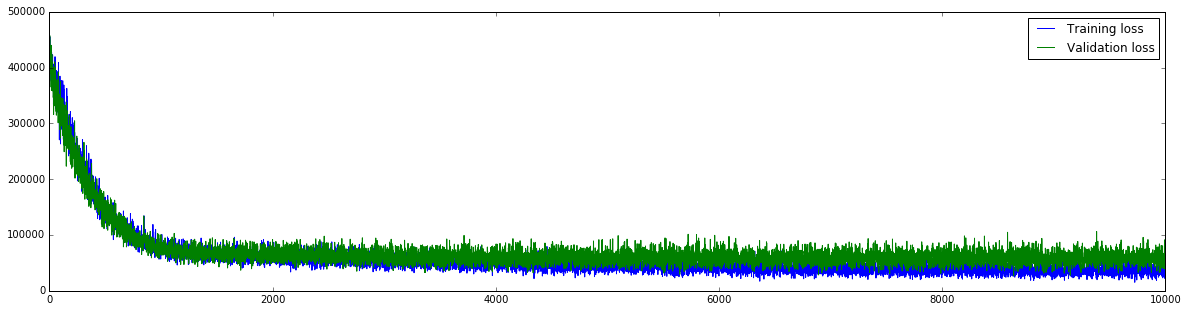

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(history)), history)
plt.plot(np.arange(len(val_history)), val_history)
plt.legend(["Training loss", "Validation loss"])

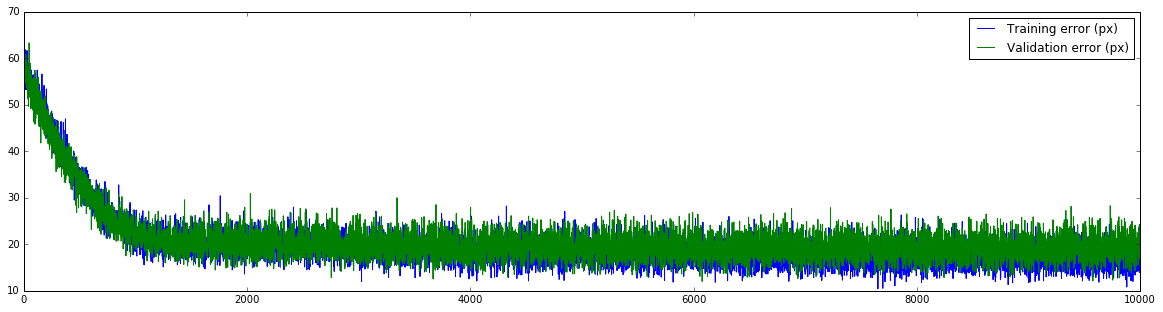

In [12]:
plt.figure(figsize=(20, 5))
plt.plot(np.arange(len(history_mse)), history_mse)
plt.plot(np.arange(len(val_history_mse)), val_history_mse)
plt.legend(["Training error (px)", "Validation error (px)"])